<a href="https://colab.research.google.com/github/suhayb-h/Acute-Lymphoblastic-Leukemia-Classifier/blob/main/3_ResNet50V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet50V2 Model

The previous CNN model demonstrated how neural networks are constructed. There are many more neural networks that are much more complex than a CNN, and such networks might result in improved performance. The previous was relatively simple, containing a total of 6 layers. In the paper "Mitosis detection in breast cancer pathology images by combining handcrafted and convolutional neural network features" by Wang et. al, the performances of 9 different neural networks were compared to one another with regards to diagnosing pathological slides. One of these models was the ResNetV2 model. For the third model in this project a ResNetV2 construction containing over 50 layers by default was used. The cell images were passed through the ResNet50V2 model to compare its performance with the CNN model constructed previously within this project.

Constructing neural networks was relatively similar amongst models. Much of the process of establishing the ResNetV2 was identical to the process for the previously created CNN model. Just as the sequential CNN model, the images in this dataset were passed through an image generator where they are rescaled and transformed (through randomly rotation and flipped horizontally or vertically). Since the test dataset had 1867 images, the validation dataset was set to 17.5% of the training dataset, equating to 1865 images. Within the generators themselves, all images were forced to retain their color and were subsequently shuffled.

Since the ResNetV2 model was substantially more complex than the CNN model. By extension there were several hyperparameters that could be adjusted to affect the overall performance of the model. There were several distinct decisions that were made in the creation of the ResNetV2 model for this report:

•	Unlike the CNN, the ResNet model could utilize pre-established weights. The weight parameter was set to the default "ImageNet" for this model.

•	The ResNetV2 model allows for a fully connected layer that lies on top of the model. A fully connected layer is dense layer that is more deeply connected with the layer below it, when compared to a traditional dense layer. This layer was turned on in the hopes of improving performance.

•	The classification by which loss was measured in this model was identical to the CNN model, being a "Binary Cross-Entropy". Since this model is a binary classifier, setting the loss classifier to binary is the most appropriate decision, just as it was for the CNN model.
5 additional layers were added to this model:

•	Three dense layers were added and were specifically designated to contain regularizer parameters. The primary purpose of the kernel and activity regularizers was to reduce overfitting. Two regularizers were available, L1 and L2, with the option to utilize both regularizers in conjunction for each parameter. Ultimately, L2 was chosen as the sole regularizer since it specifically serves the function of reducing overfitting.

•	The final output layer of this model was set to a sigmoid activating dense layer with two output nodes. This final output layer serves to provide a binary classification system between two results, those being cancerous and non-cancerous.

For the purposes of this preliminary report, an early stop was set in place for this model based on insufficient improvements in validation accuracy. This was the same strategy used for the sequential CNN model. Based on the preliminary analysis of 26 epochs, this model seems to have a lot of room for parameter optimization as there is definite overfitting of the training data.
The final phase of analysis was to assess the model’s performance on the testing data. Just as before, the testing data was imported via a dataframe image generator. This model showcased a test accuracy of 66%. Despite the overall accuracy being lower, fewer normal lymphoblasts were misdiagnosed as ALL cells. Additionally, more normal lymphoblasts were correctly labelled when compared to the sequential CNN model.

Independent testing in turning on the fully connected top dense layer and allowing the default layers to be trainable resulted in increased performance but significant overfitting. Adding more layers or tuning parameters within these layers might have allowed for these two features to be active while reducing overfitting. Furthermore, this specific model is called the ResNet50V2 because it has 50 default layers and is the second iteration of the model. A V3 does exist and might result in improved performance, while other ResNet models exist with thousands of layers. Above all else, one feature within this model holds the most potential for improved performance, that being the allowance for weight data. ImageNet was specifically decided against since these weights were established from the differentiation of everyday objects instead of minutia between extremely similar cells. A medical ImageNet does exist but is over 1000 terabytes in size. Being able to train any medical image classifier on this specific weight library might result in the highest possible performance.

<hr color=red>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

In [ ]:
# Created training image data-generator.
train_datagen = \
ImageDataGenerator(rescale = 1./255, 
                   rotation_range = 180, 
                   horizontal_flip = True, 
                   vertical_flip = True, 
                   validation_split = 0.175)

# Specified where images should be loaded from as well as additional attributes:
train_generator = \
train_datagen.flow_from_directory(
    '/content/drive/Othercomputers/My MacBook Air/C-NMC_Leukemia/training_data', 
    target_size = (224, 224), 
    color_mode = 'rgb', 
    class_mode = 'categorical',
    shuffle = True, 
    subset = 'training')

validation_generator = \
train_datagen.flow_from_directory(
    '/content/drive/Othercomputers/My MacBook Air/C-NMC_Leukemia/training_data', 
    target_size = (224, 224), 
    color_mode = 'rgb', 
    class_mode = 'categorical',
    shuffle = True, 
    subset = 'validation')

Found 8796 images belonging to 2 classes.
Found 1865 images belonging to 2 classes.


In [ ]:
# Specify how the machine names classes:
class_names = validation_generator.class_indices
class_names

{'all': 0, 'hem': 1}

In [ ]:
# Weight of 2.15 is applied to 'hem' cells
weights = {0: 1,
           1: 2.15}

In [ ]:
resnet_model = ResNet50V2(weights = 'imagenet',
                   include_top = True,
                   input_shape = (224, 224, 3))
resnet_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
for layer in resnet_model.layers:
    layer.trainable = True

In [ ]:
# Added a flatten layer
x0 = Flatten()(resnet_model.output)

In [ ]:
# Added Dense Layers
x1 = Dense(128, activation="relu", kernel_regularizer = regularizers.L2(0.01), activity_regularizer = regularizers.L2(0.01))(x0)
x2 = Dense(64, activation="relu", kernel_regularizer = regularizers.L2(0.01), activity_regularizer = regularizers.L2(0.01))(x1)
x3 = Dense(32, activation="relu", kernel_regularizer = regularizers.L2(0.01), activity_regularizer = regularizers.L2(0.01))(x2)
output = Dense(2, activation="sigmoid")(x3) # <-- The final output layer of the model is set to a sigmoidal activator with 2 nodes, signifying 2 binary outcomes

In [ ]:
model = Model(inputs = resnet_model.input, 
              outputs = output)

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['categorical_accuracy'])

In [ ]:
# Training stopped early once there were no improvements in validation accuracy
early_stop = EarlyStopping(monitor = 'val_categorical_accuracy', 
                           patience = 10, 
                           verbose = 1)

model_2 = model.fit(train_generator,
          epochs = 50,
          validation_data = validation_generator,
          class_weight = weights,
          callbacks = [early_stop])

Epoch 1/50
275/275 [==============================] - 136s 463ms/step - loss: 1.3645 - categorical_accuracy: 0.6706 - val_loss: 0.6776 - val_categorical_accuracy: 0.6895
Epoch 2/50
275/275 [==============================] - 125s 454ms/step - loss: 0.8635 - categorical_accuracy: 0.7134 - val_loss: 0.6725 - val_categorical_accuracy: 0.6847
Epoch 3/50
275/275 [==============================] - 125s 456ms/step - loss: 0.7402 - categorical_accuracy: 0.7797 - val_loss: 0.6208 - val_categorical_accuracy: 0.7464
Epoch 4/50
275/275 [==============================] - 126s 457ms/step - loss: 0.7088 - categorical_accuracy: 0.7991 - val_loss: 0.6977 - val_categorical_accuracy: 0.6842
Epoch 5/50
275/275 [==============================] - 125s 454ms/step - loss: 0.6762 - categorical_accuracy: 0.8247 - val_loss: 0.6993 - val_categorical_accuracy: 0.6842
Epoch 6/50
275/275 [==============================] - 125s 455ms/step - loss: 0.6333 - categorical_accuracy: 0.8288 - val_loss: 0.7152 - val_categoric

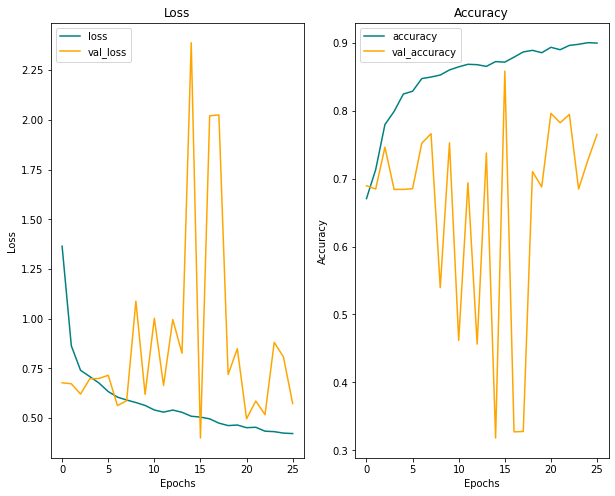

In [ ]:
plt.figure(figsize = (10, 8))

plt.subplot(1, 2, 1, title = "Loss")
plt.plot(model_2.history['loss'], 
         color = 'teal', 
         label = 'loss')
plt.plot(model_2.history['val_loss'], 
         color = 'orange', 
         label = 'val_loss')
plt.legend(loc = "upper left")
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2, title = "Accuracy")
plt.plot(model_2.history['categorical_accuracy'], 
         color = 'teal', 
         label = 'accuracy')
plt.plot(model_2.history['val_categorical_accuracy'], 
         color = 'orange', 
         label = 'val_accuracy')
plt.legend(loc = "upper left")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.show()

In [ ]:
df_test = \
pd.read_csv(
    '/content/drive/Othercomputers/My MacBook Air/'
    'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv', 
    dtype = str)

# a new column called labels_ was created wherein 'all' patients are labelled 0 
df_test.loc[df_test['Patient_ID'].str.contains('all'), 'true_labels'] = '0'

# labels_ was also given a label 1 for any patients that were non-cancerous
df_test.loc[df_test['Patient_ID'].str.contains('hem'), 'true_labels'] = '1'

df_test

,Patient_ID,new_names,labels,true_labels
0,UID_57_29_1_all.bmp,1.bmp,1,0
1,UID_57_22_2_all.bmp,2.bmp,1,0
2,UID_57_31_3_all.bmp,3.bmp,1,0
3,UID_H49_35_1_hem.bmp,4.bmp,0,1
4,UID_58_6_13_all.bmp,5.bmp,1,0
...,...,...,...,...
1862,UID_54_33_1_all.bmp,1863.bmp,1,0
1863,UID_55_24_1_all.bmp,1864.bmp,1,0
1864,UID_H32_20_1_hem.bmp,1865.bmp,0,1
1865,UID_54_30_2_all.bmp,1866.bmp,1,0


In [ ]:
# Apply the same rescaling factor as our other generators
test_datagen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range = 180, 
                                  horizontal_flip = True, 
                                  vertical_flip = True)
test_generator = \
test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = \
    '/content/drive/Othercomputers/My MacBook Air/'
    'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data',
    target_size = (224, 224),
    batch_size = 100,
    x_col = 'new_names',
    y_col = 'true_labels',
    color_mode = 'rgb',
    class_mode = 'categorical')

X_test, y_test = test_generator.next()

Found 1867 validated image filenames belonging to 2 classes.


In [ ]:
# Evaluate the model's performance on the test data
score = model.evaluate(X_test, y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

4/4 [==============================] - 1s 97ms/step - loss: 0.6995 - categorical_accuracy: 0.6600
Test loss: 0.6994901895523071
Test accuracy: 0.6600000262260437


In [ ]:
# Calculate the predictions
predict_probas = model.predict(X_test)

# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

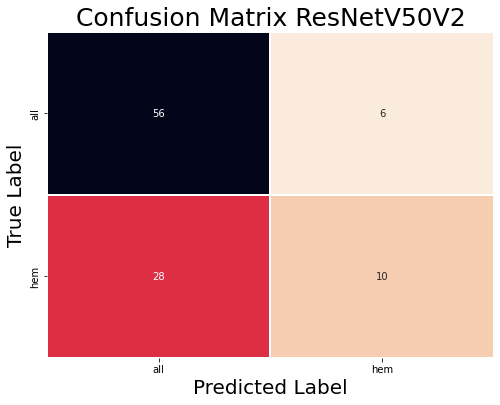

In [ ]:
class_names = validation_generator.class_indices

y_test_labels = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_test_labels, y_predict)

plt.figure(figsize = (8,6))
sns.heatmap(conf_mat,
            annot=True,
            cbar=False,
            xticklabels = class_names,
            yticklabels = class_names,
            cmap = "rocket_r",
            linewidths = 1)
plt.title('Confusion Matrix ResNetV50V2', 
          size = 25, 
          y = 1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

<hr color=red>

# Significance of Research
This project meant to serve as a case study to assess the efficacy of utilizing neural networks and machine learning to diagnose ALL. Despite not establishing a practical model, it is worth reflecting on the potential for this area of research.

The initial phase of this project was an exploration to better understand the limitations of machine learning. Despite having a small sample size, computational resources were consistently an issue when dealing with image data. Any classic modelling techniques were impossible to execute since they required dealing with images as NumPy arrays. Such attempts caused even cloud GPUs to fail. Dealing with images through tensor-based data generators proved to utilize GPU power much more efficiently. There are several experimental models worth exploring to assess their performance, but these models are still in their preliminary development phases with very little documentation available on hyperparameter optimization. Several experimental models, such as TensorFlow based decision tree models, require giant arrays of flattened individual image arrays. Such processes require extensive GPU power to read the arrays and the arrays themselves can exceed several hundred gigabytes in size. Regardless, implementing these models might provide new useful insights should the computational power become more easily accessible.

This was a relatively small dataset, with only 12528 images available to train and test on. Furthermore, there is a class imbalance of roughly 69% cancer cells to 31% healthy lymphoblasts in the training dataset. Both factors can negatively impact the establishment of an effective neural network model. These issues were address by implementing weights directly into the model, but such a technique is still not ideal compared to having a more substantial dataset to being with. While some of the data could have been excluded to better balance the distribution, having less data can result in substantially worse performance. For the purposes of this project all images were utilized.

Neural network optimization is a mundane and iterative process. For the sequential CNN, more layers could be added, layers can be removed, and parameters can be continued to be tweaked, but until the model is trained there is no means of knowing what combination works best for the model. The initial exploratory data analysis revealed a clear differentiation of cells based on size and eosin colour distribution, so adjusting the mathematical formulas of individual layers to better select for these two variables might result in a better performing model.